In [24]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import IPython.display as ipd
import sklearn as sk
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.compose

In [44]:
data = pd.read_csv('datasets/bikesharing-day.csv')

data.dteday = pd.to_datetime(data.dteday, format='%Y-%m-%d').dt.normalize()
data.season = data.season.astype('category')
data.mnth = data.mnth.astype('category')
data['day'] = data.dteday.dt.dayofyear
if ('hr' in data):
    data.hr = data.hr.astype('category')
data.weekday = data.weekday.astype('category')
data.weathersit = data.weathersit.astype('category')

data.cnt = data.cnt.astype(float)
data.instant = data.instant.astype(float)
data.weathersit = data.weathersit.astype(float)

In [46]:
columns = ['instant','day','yr', 'workingday', 'season','weekday','holiday','temp','hum', 'weathersit','windspeed', 'cnt']
# columns = ['instant','cnt']
projected_data = data.loc[:, columns]
train, test = sk.model_selection.train_test_split(projected_data)

ct = sk.compose.ColumnTransformer([
    ('col',sk.preprocessing.OneHotEncoder(categories='auto'),[
        'season', 'weekday'
    ])
], remainder='passthrough')

In [32]:
ss = sk.preprocessing.StandardScaler()
def regression_model(model, predict, param_grid=None, transform=True):
    print('Start {type(model).__name__}')
    variates = train.columns.drop(predict).drop('instant')
    
    trainX = train.loc[:, variates]
    trainy = train.loc[:, [predict]]

    testX = test.loc[:, variates]
    testy = test.loc[:, [predict]]
    
    if transform:
        #ct.fit(projected_data.loc[:,variates]);
        #trainX = ct.transform(trainX)
        #testX = ct.transform(testX)
        trainy = ss.fit_transform(trainy)
    
    if param_grid:
        rgs = sk.model_selection.RandomizedSearchCV(model, param_distributions=param_grid, cv=10, n_iter=4, n_jobs=-1, verbose=4)
        rgs.fit(trainX, trainy.ravel())
    else:
        model.fit(trainX,trainy.ravel())
        
    
    predictedy = ss.inverse_transform((model if not param_grid else rgs).predict(testX))
    print('Done {type(model).__name__}')
    return pd.Series({
        'RMSE': np.sqrt(sk.metrics.mean_squared_error(testy,predictedy)),
        'MAE': sk.metrics.mean_absolute_error(testy,predictedy),
        'model': model if not param_grid else rgs
    }, name=type(model).__name__)

In [33]:
ss = sk.preprocessing.StandardScaler()
def classification_model(model, predict, param_grid=None, transform=True):
    variates = train.columns.drop(predict).drop('instant')
    
    trainX = train.loc[:, variates]
    trainy = train.loc[:, [predict]]

    testX = test.loc[:, variates]
    testy = test.loc[:, [predict]]
    
    if transform:
        #ct.fit(projected_data.loc[:,variates]);
        #trainX = ct.transform(trainX)
        #testX = ct.transform(testX)
        trainy = ss.fit_transform(trainy)
    
    if param_grid:
        rgs = sk.model_selection.RandomizedSearchCV(model, param_distributions=param_grid, cv=10, n_iter=4, n_jobs=-1, verbose=4)
        rgs.fit(trainX, trainy.values.ravel())
    else:
        model.fit(trainX,trainy.values.ravel())
        
    
    predictedy = (model if not param_grid else rgs).predict(testX)
    return pd.Series({
        'ACC': np.sqrt(sk.metrics.accuracy_score(testy,predictedy)),
        'model': model if not param_grid else rgs
    }, name=type(model).__name__)

In [48]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


models = pd.DataFrame([classification_model(m, 'weekday', transform=False, param_grid=pg) for m,pg in [
    (LogisticRegression(),None),
    (KNeighborsClassifier(), None),
    (SVC(), None),
    (GradientBoostingClassifier(),None),
]]).sort_values('ACC')
models

/home/omadson/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/omadson/.local/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/omadson/.local/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


,ACC,model
SVC,0.286299,"SVC(C=1.0, cache_size=200, class_weight=None, ..."
KNeighborsClassifier,0.391159,"KNeighborsClassifier(algorithm='auto', leaf_si..."
LogisticRegression,0.548221,"LogisticRegression(C=1.0, class_weight=None, d..."
GradientBoostingClassifier,0.553183,([DecisionTreeRegressor(criterion='friedman_ms...


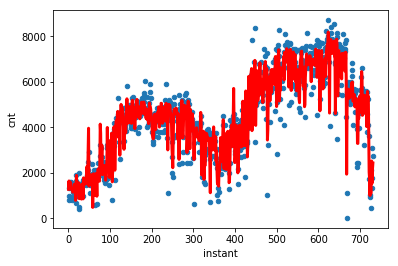

In [11]:
ax = projected_data.plot.scatter(x='instant',y='cnt')
ax.plot(projected_data.loc[:,'instant'], ss.inverse_transform(models.loc['GradientBoostingRegressor','model'].predict(projected_data.drop(columns=['instant','cnt']))), color='red', linewidth=3)

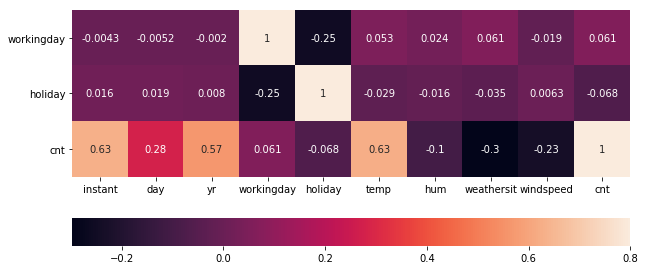

In [75]:
corrmat = projected_data.corr()
f, ax = mpl.pyplot.subplots(figsize=(10, 5))
sns.heatmap(corrmat.iloc[[3,4,-1],:], vmax=.8, square=True, cbar_kws={"orientation": "horizontal"}, annot=True)

mpl.pyplot.show()